In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix


import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras

import pickle
from datetime import datetime

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [111]:
def label_smoother(aerial, gsv):
    mapping = {
        (0, 0): 0,
        (1, 0): 2,
        (2, 0): 0,
        (0, 1): 2,
        (1, 1): 1,
        (2, 1): 1,
        (0, 2): 0,
        (1, 2): 1,
        (2, 2): 2
    }
    return mapping[(int(aerial), int(gsv))]

def clean_labels_redfin(labels):
    labels = labels[['has_parking','MBL']]
    return labels

def clean_labels_hand(labels):
    # smooth labels
    # labels = labels[~((labels['AERIAL_Driveway'] == 2) & (labels['GSV_Driveway'] == 2))]
    labels['final_label']= labels.apply(lambda x: label_smoother(x['AERIAL_Driveway'],x['GSV_Driveway']), axis = 1)
    labels = labels[['final_label', 'MBL']]
    return labels

In [115]:
labels_redfin_path = '../data/redfin_clean.csv'
labels_hand_path = '../data/training/all_labels.csv'
garage_path = '../data/garage.csv'
tabular_path = '../data/residence_addresses_googlestreetview_clean.csv'

# import dataframe with filenames and labels
labels_redfin = pd.read_csv(labels_redfin_path)
labels_redfin = labels_redfin.fillna(2)

# import data by hand
labels_hand = pd.read_csv(labels_hand_path)
labels_hand = labels_hand.fillna(2)

# load garages
garages = pd.read_csv(garage_path, index_col=0)

# load tabular data
tabular = pd.read_csv(tabular_path, index_col = 0)

In [116]:
labels_redfin_clean = clean_labels_redfin(labels_redfin)
labels_hand_clean = clean_labels_hand(labels_hand)

In [117]:
label_count = labels_hand.final_label.value_counts()
percent_driveway = label_count[1]/(label_count[1] + label_count[0]) 
percent_driveway

0.815242494226328

In [126]:
labels_clean = labels_hand_clean.merge(labels_redfin_clean, how = 'outer').merge(garages, how = 'outer')

In [127]:
labels_clean.has_parking = labels_clean.apply(
    lambda row: row.has_parking if not np.isnan(row.has_parking) else 
                row.HAS_GARAGE if not np.isnan(row.HAS_GARAGE) else row.final_label , axis = 1
)
labels_clean = labels_clean.drop(['final_label', 'HAS_GARAGE'], axis = 1)

In [287]:
labels_clean.to_csv('../data/labels_final.csv')

In [128]:
def upsample(df):
    # upsample
    n1 = sum((df.has_parking == 1) | (df.has_parking == 0.9))
    n0 = sum((df.has_parking == 0) | (df.has_parking == 0.1))
    labels0 = df[(df.has_parking == 0) | (df.has_parking == 0.1)]
    labels0_upsample = labels0.sample(n1 - n0, replace = True)
    labels_all_upsampled = pd.concat([df, labels0_upsample])
    return labels_all_upsampled

In [129]:
df = labels_clean.merge(tabular)

In [130]:
df

MBL  has_parking       BLDG_VAL       LAND_VAL     OTHER_VAL  LOT_SIZE       LS_PRICE  YEAR_BUILT  BLD_AREA     UNITS     RES_AREA  STORIES  NUM_ROOMS  LOT_UNITS  BLD_AREA_MISSING  BLDG_VAL_MISSING  LOT_SIZE_MISSING      LS_YEAR  101  102  104  105  111  112  130  322  325  326  332  340       995  1010      1020  1040  1050  1090  1110  1120  1220  9450  9570  9610  9700  112C  957R  959R  970C  ASMD   BA   BB  CBD  CCD45  CCD55   IA   IP   NB   OS   RA   RB   RC  TOD 100  TOD55  TOD70   UN   rb  2 Fam Conv  2-Decker  2-Decker-Apts  3 fam Conv  3-Decker  3-Decker-Apts  Apartments  Condominium  Conventional  Conventional-Apts  Cottage  Cottage Bungalow  Duplex  Fam Conv  Family Duplex  Family Duplex-Apts  Low rise  Mansard  Mansard-Apts  Mid Rise Apartments  Mid rise  Row End  Row End-Apts  Row Mid  Row Mid-Apts  Row Middle  Stores/Apt Com  Three decker  Townhouse  Townhouse end  Townhouse middle  Two Family  Two Family-Apts  Two decker  Victorian  1ST_CLOSEST  2ND_CLOSEST  \
0     47-G-17          0.0  270300.000000  254500.000000  17888.245551  0.140000  380000.000000      1920.0    4827.0  4.215987  2260.000000  2.30000  11.000000  10.207792               0.0          0.000000          0.000000  2011.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   0.0  0.000000   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0    0.0    0.0  0.0  0.0         0.0       1.0            0.0         0.0       0.0            0.0         0.0     0.000000           0.0                0.0      0.0               0.0     0.0       0.0            0.0                 0.0       0.0      0.0           0.0                  0.0       0.0      0.0           0.0      0.0           0.0         0.0             0.0           0.0        0.0            0.0               0.0    0.000000              0.0         0.0        0.0    10.843022    14.793315   
1     38-A-47          1.0  444700.000000  399300.000000  17888.245551  0.050000  484000.000000      1902.0    4392.0  4.215987  2831.000000  2.80000  11.000000  10.207792               0.0          0.000000          0.000000  2007.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   0.0  0.000000   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0    0.0    0.0  0.0  0.0         1.0       0.0            0.0         0.0       0.0            0.0         0.0     0.000000           0.0                0.0      0.0               0.0     0.0       0.0            0.0                 0.0       0.0      0.0           0.0                  0.0       0.0      0.0           0.0      0.0           0.0         0.0             0.0           0.0        0.0            0.0               0.0    0.000000              0.0         0.0        0.0    12.435779    24.170080   
2     44-A-48          0.0  362400.000000  306500.000000  17888.245551  0.020000  520000.000000      1900.0    2699.0  4.215987  1525.000000  2.50000   8.000000  10.207792               0.0          0.000000          0.000000  2013.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   1.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0    0.0    0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0    0.0    0.0  0.0  0.0         0.0       0.0            0.0         0.0       0.0            0.0         0.0     0.000000           1.0                0.0      0.0               0.0     0.0       0.0            0.0                 0.0       0.0      0.0           0.0                  0.0       0.0      0.0           0.0      0.0           0.0         0.0             0.0           0.0        0.0            0.0               0.0    0.000000              0.0         0.0        0.0     9.047318    10.233254   
3     

# EDA

In [131]:
import seaborn as sns
#scaler = StandardScaler()
#df_viz = scaler.fit_transform(df.drop('MBL', axis = 1))
df_viz = pd.DataFrame(df, columns = df.columns.drop(['MBL']))
df_viz = upsample(df_viz)

/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


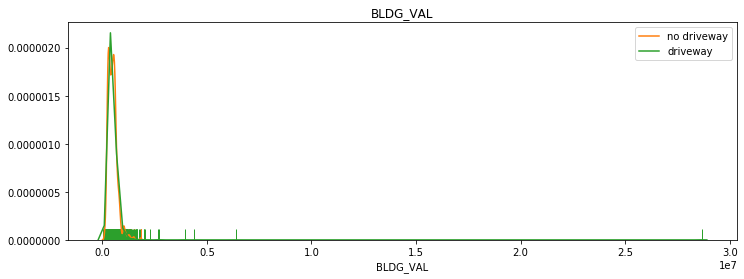

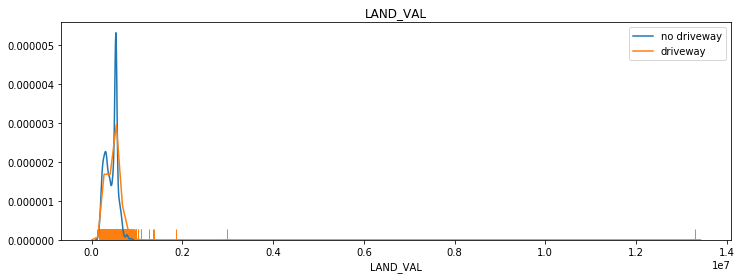

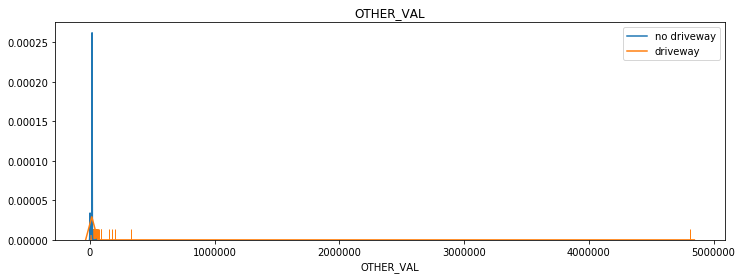

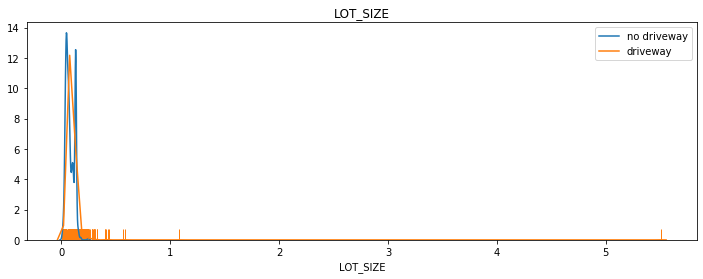

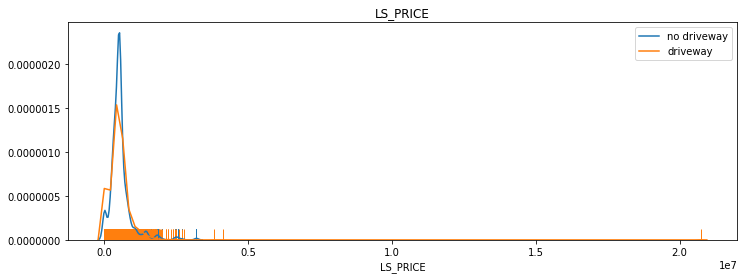

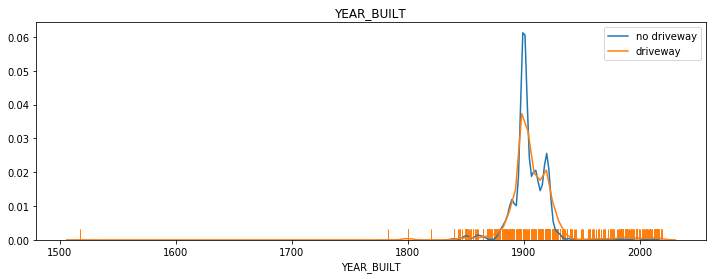

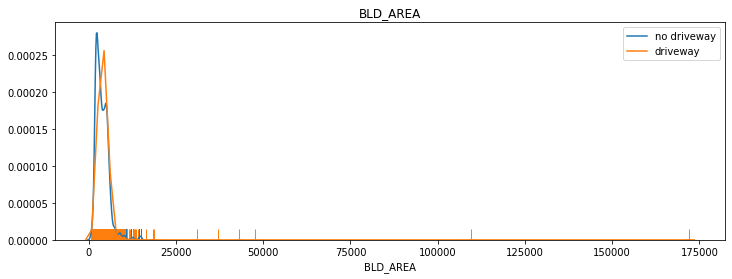

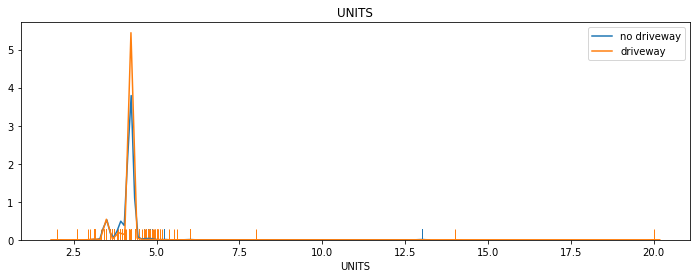

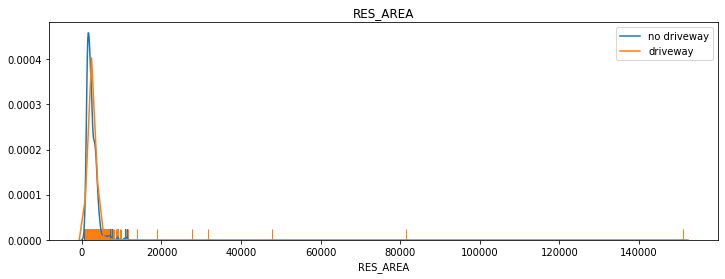

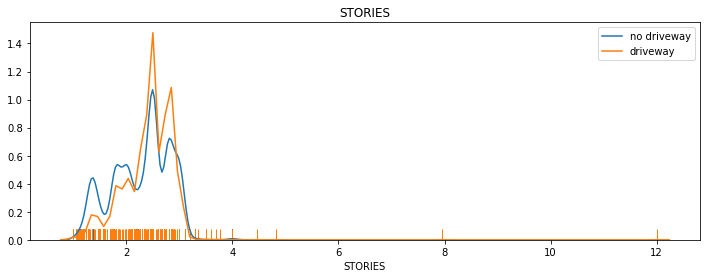

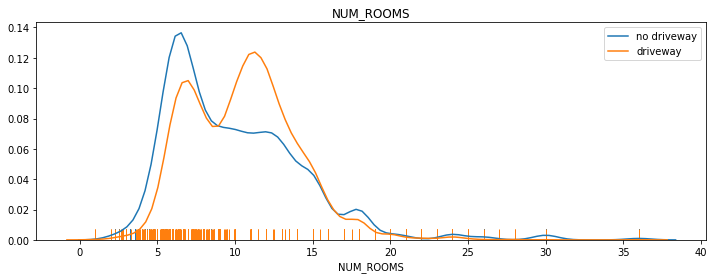

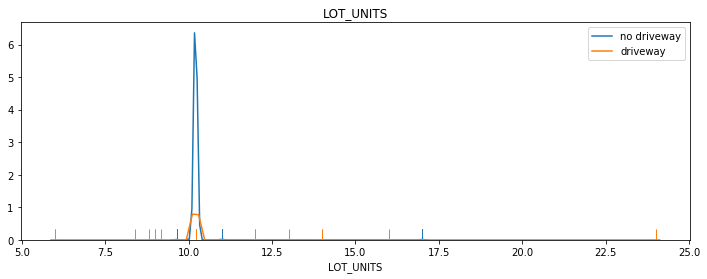

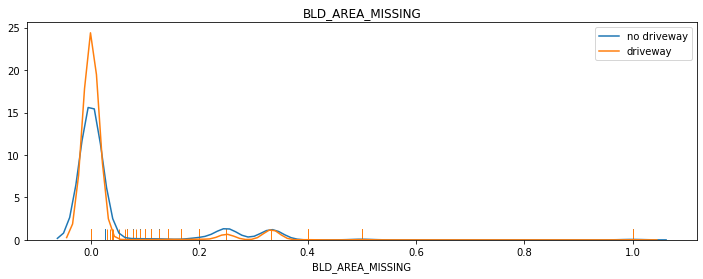

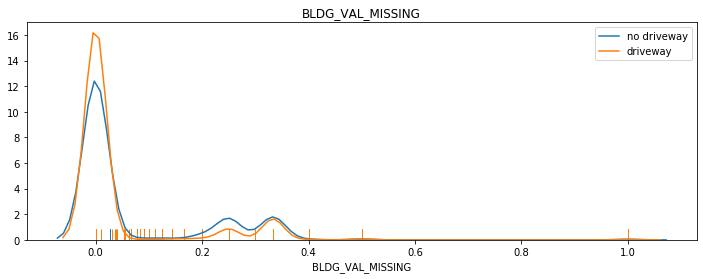

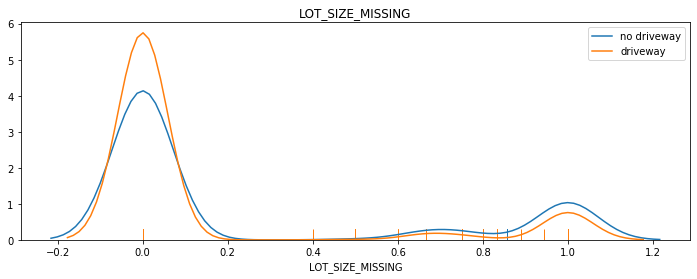

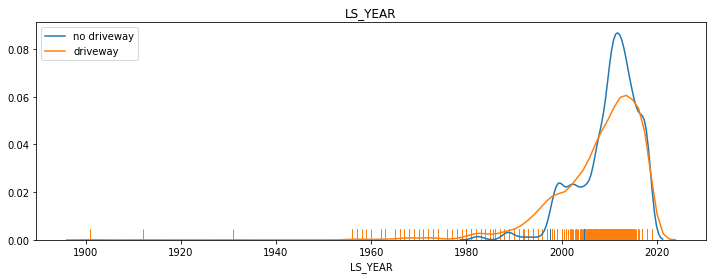

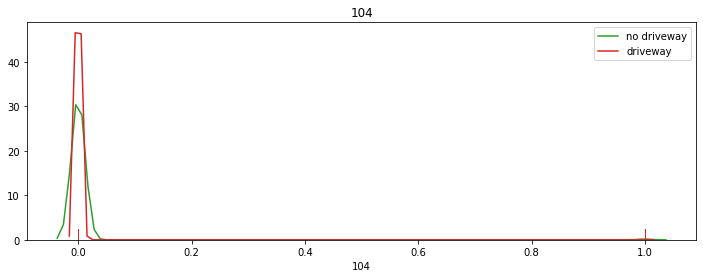

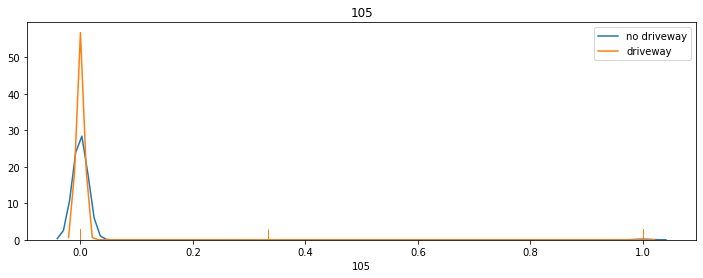

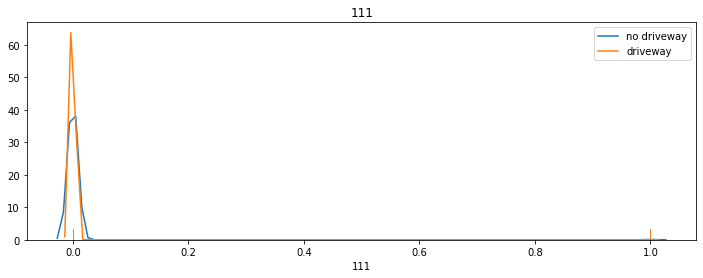

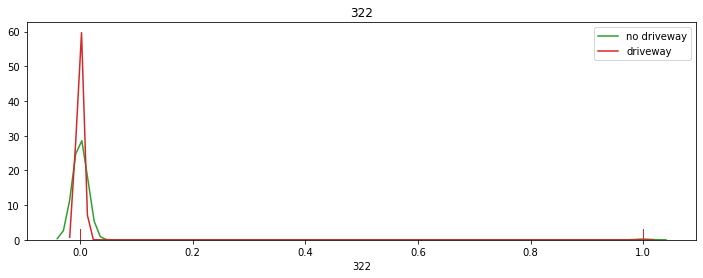

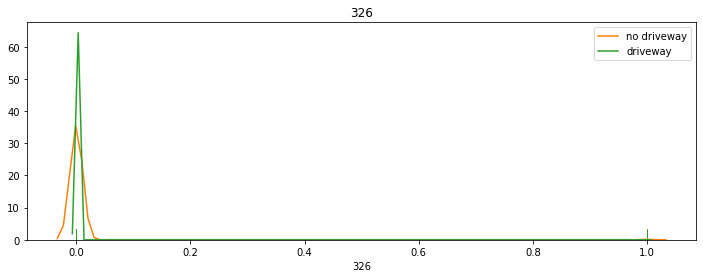

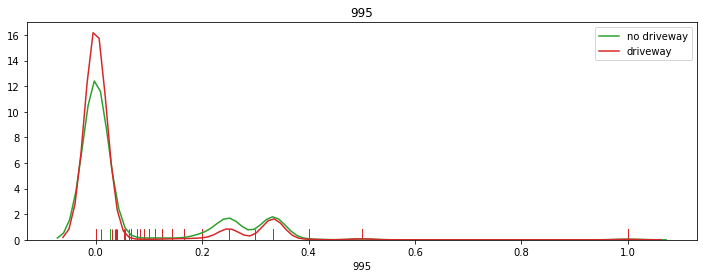

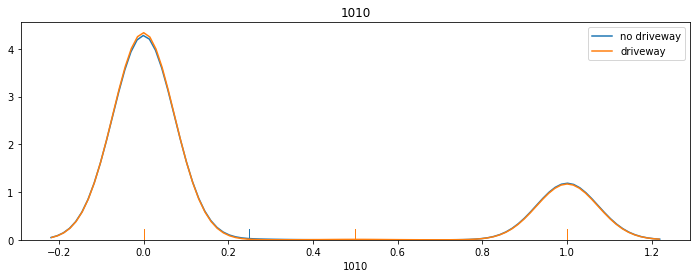

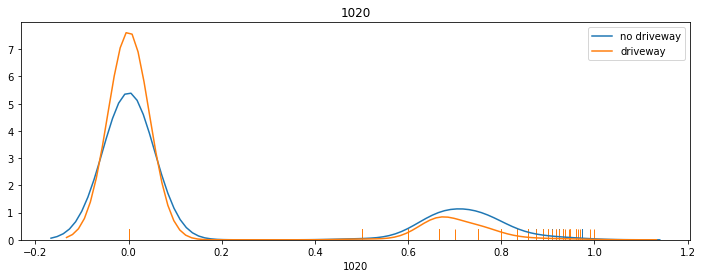

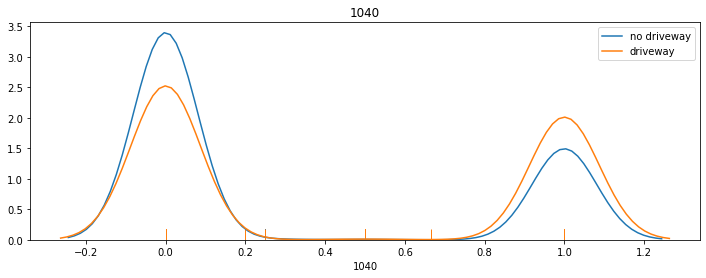

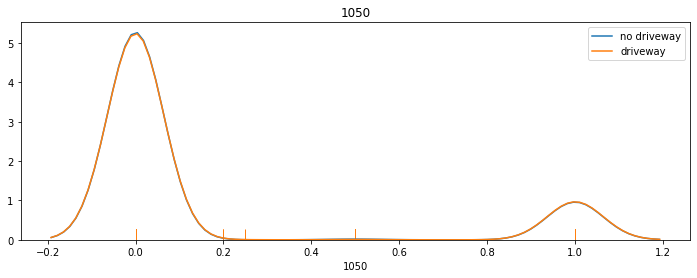

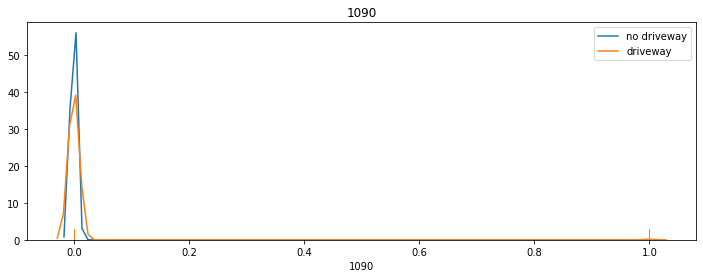

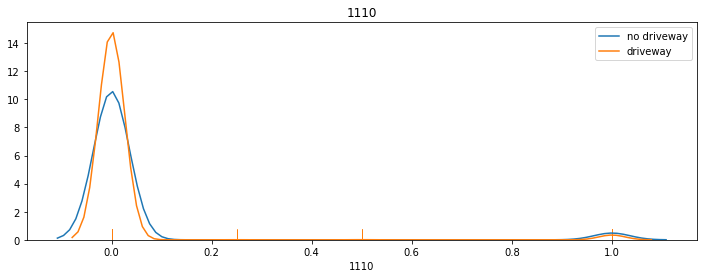

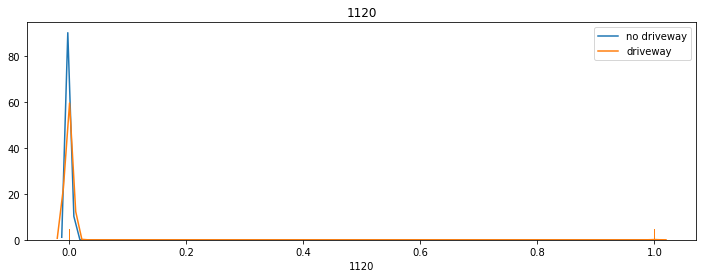

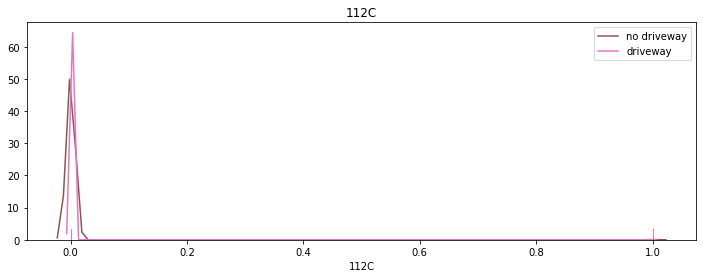

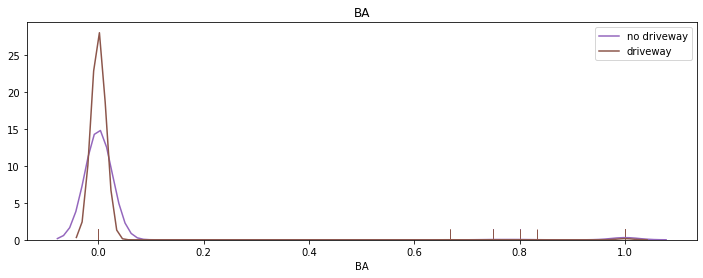

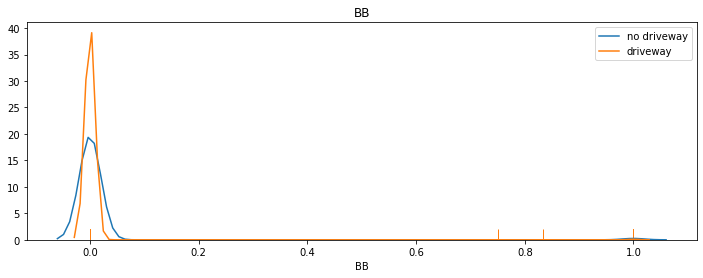

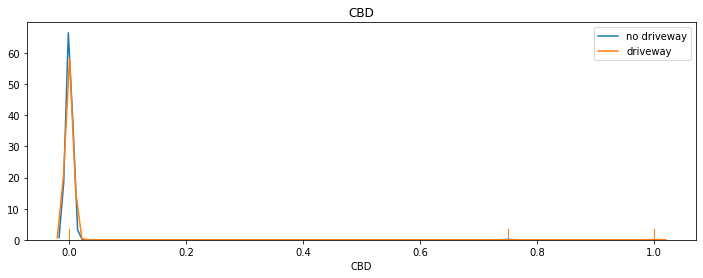

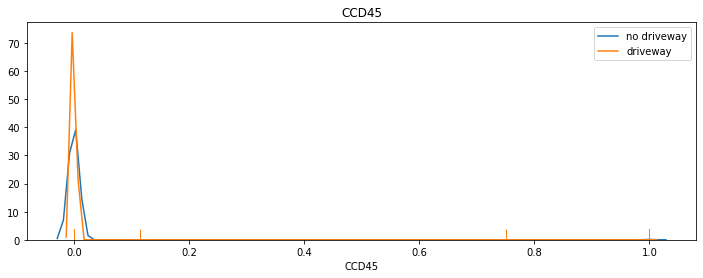

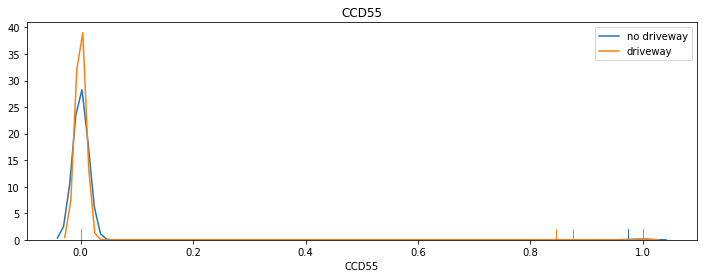

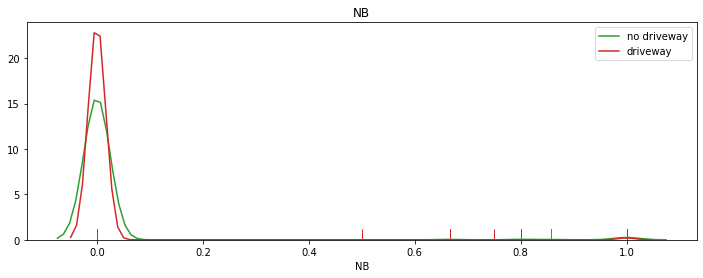

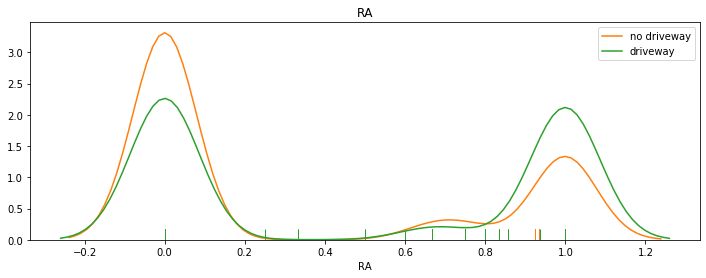

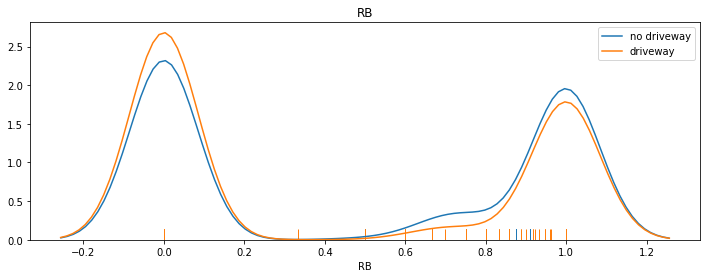

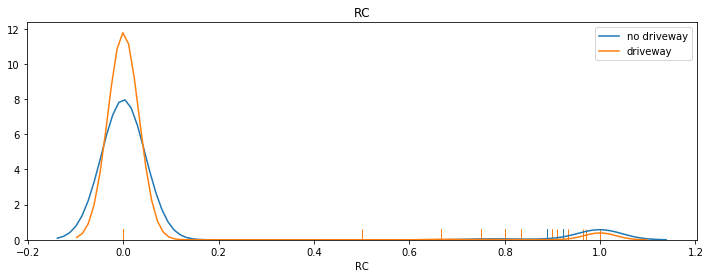

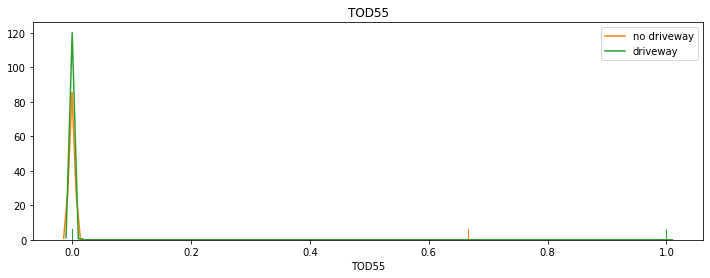

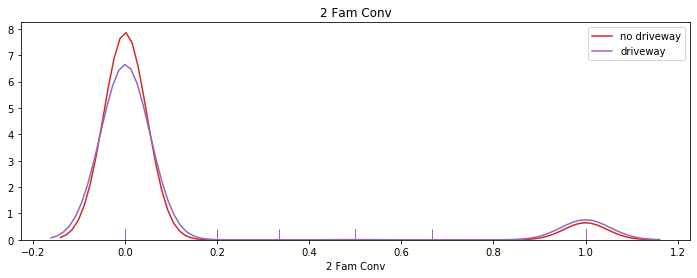

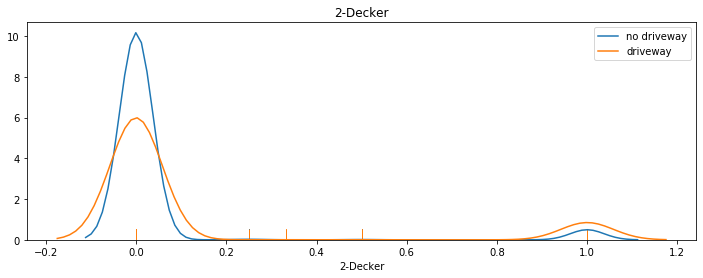

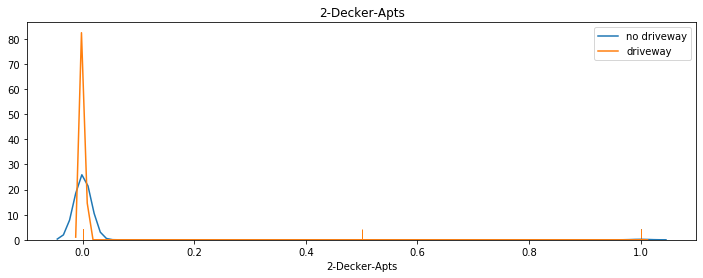

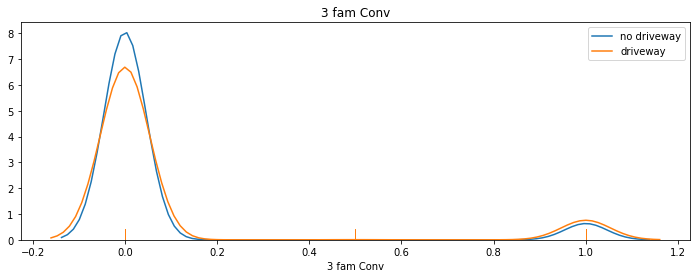

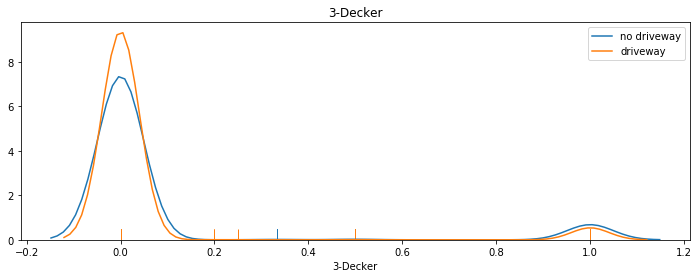

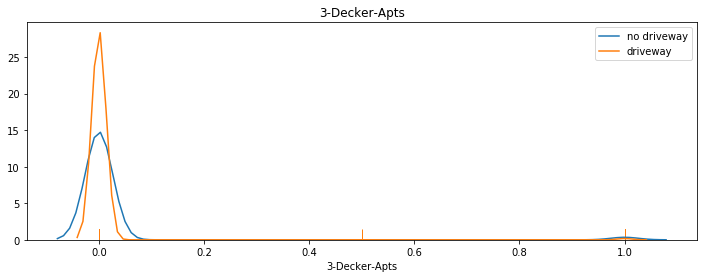

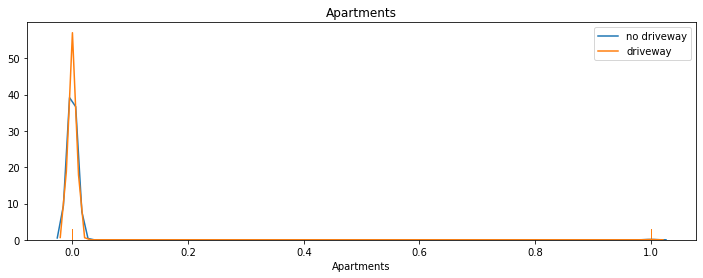

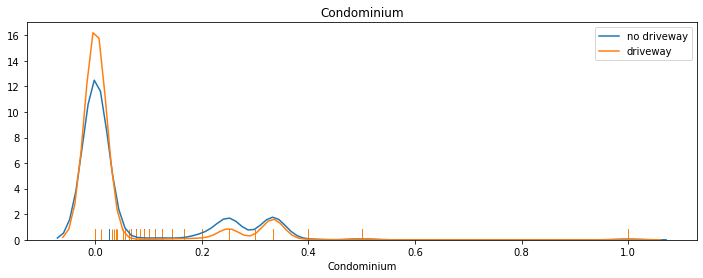

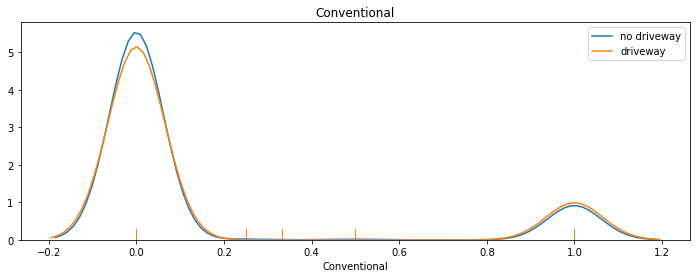

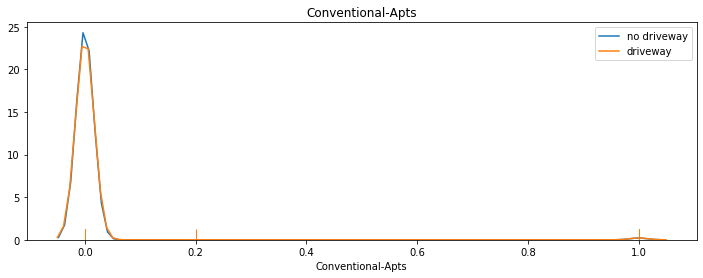

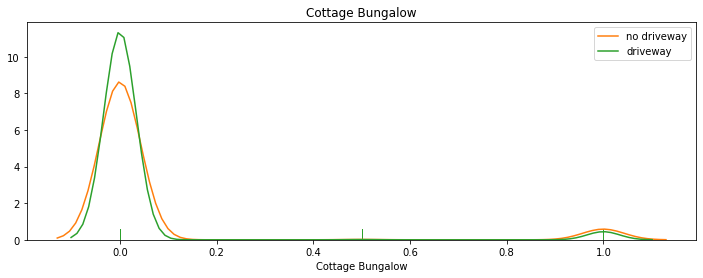

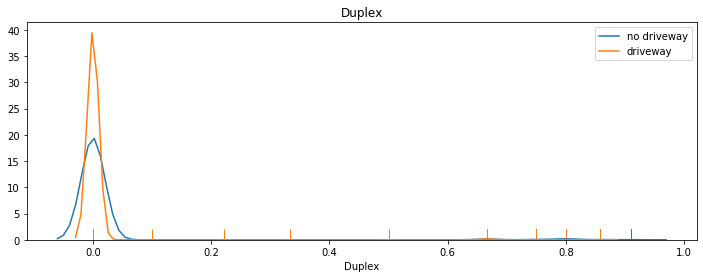

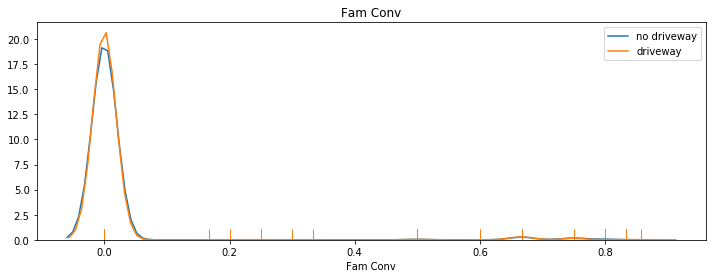

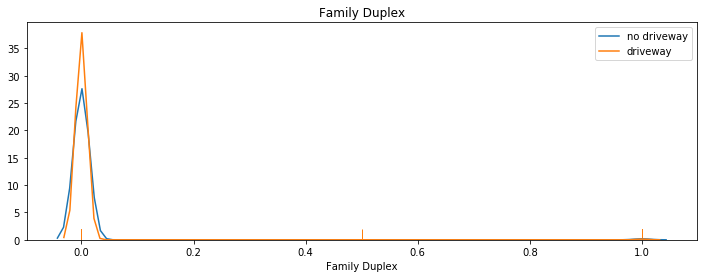

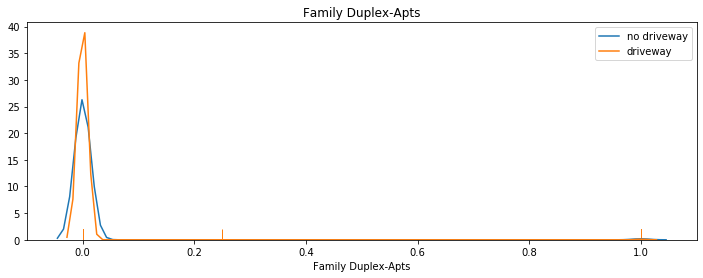

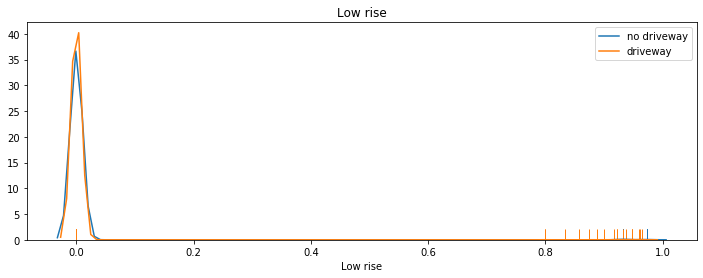

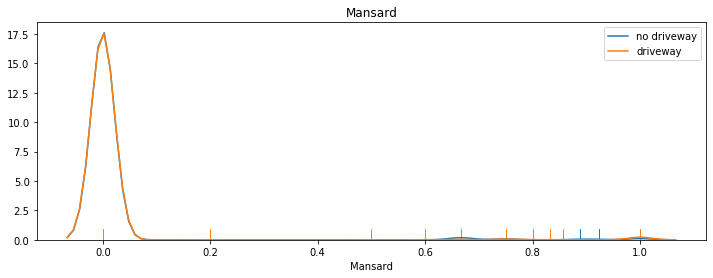

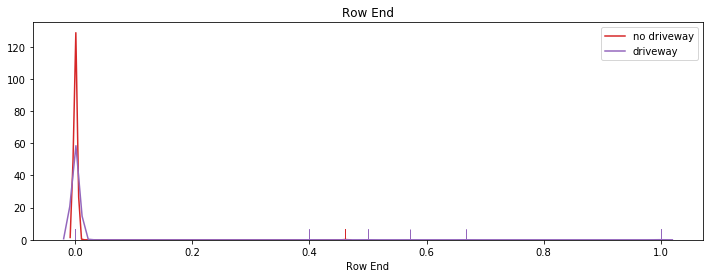

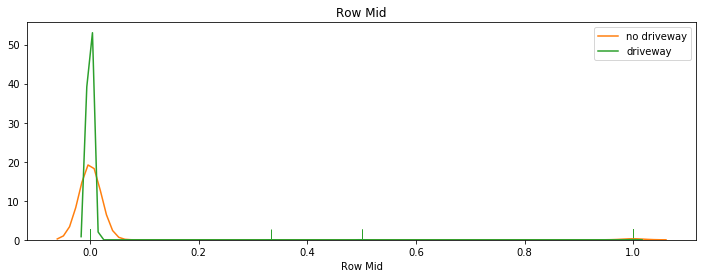

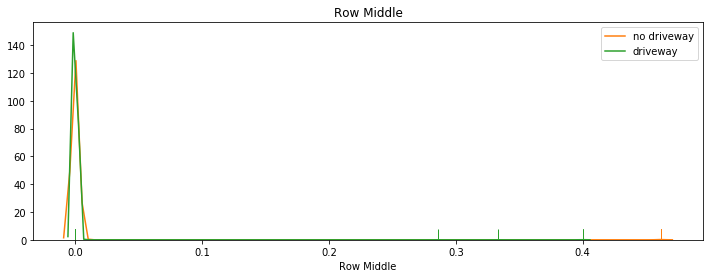

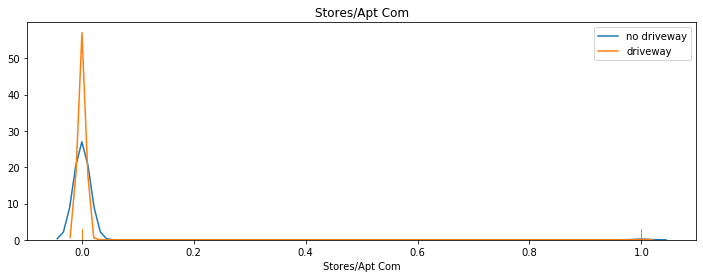

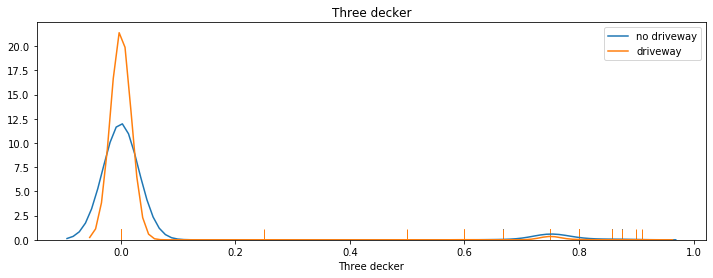

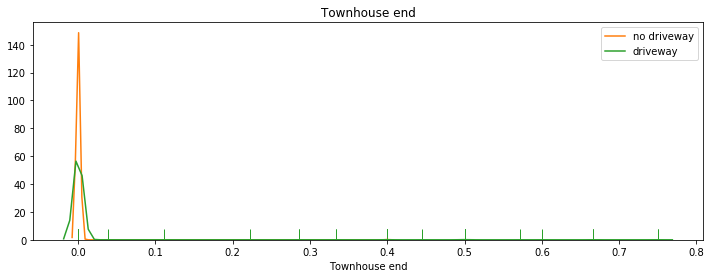

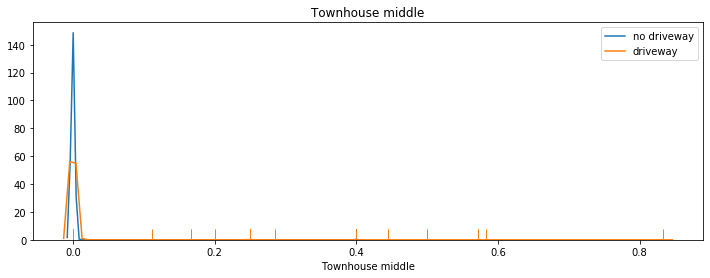

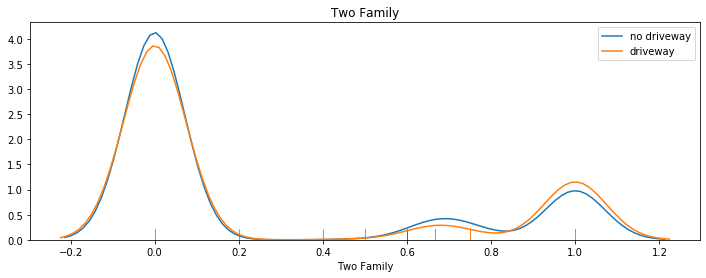

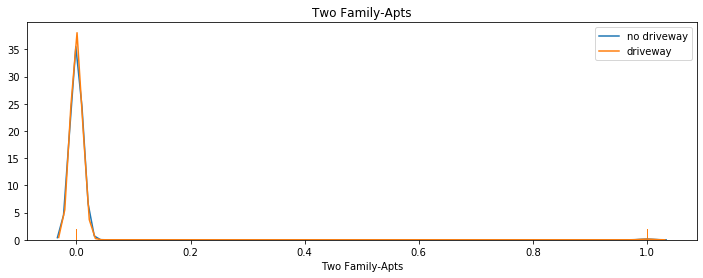

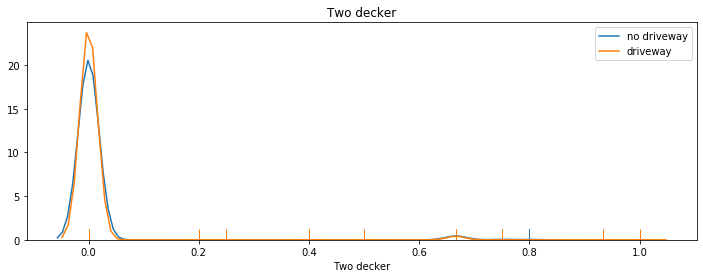

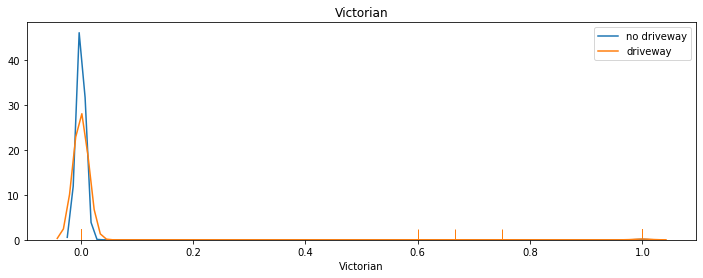

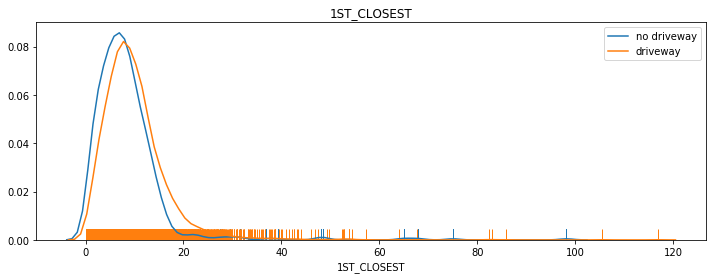

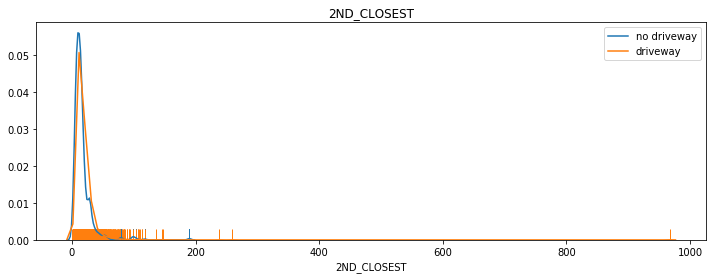

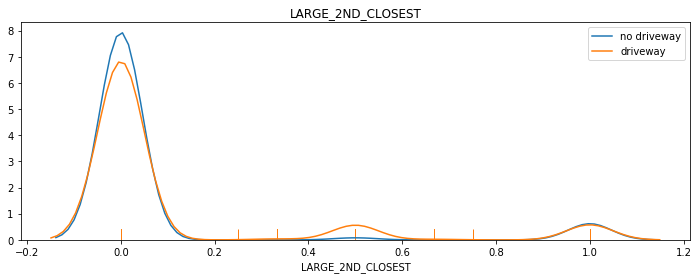

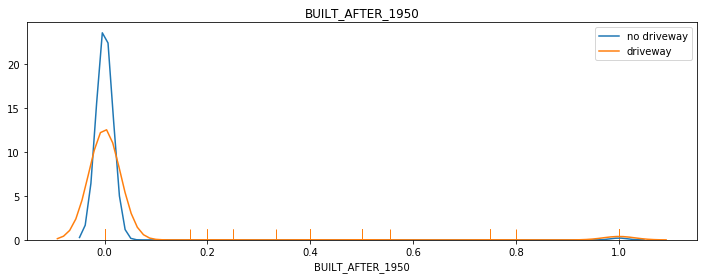

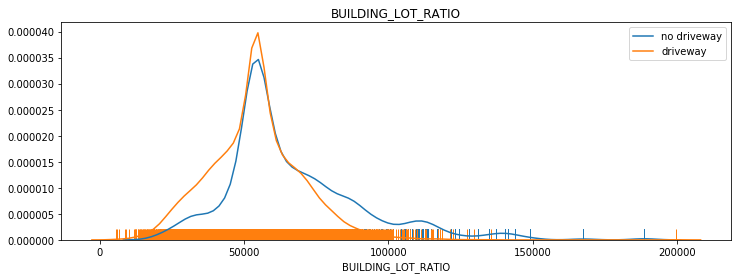

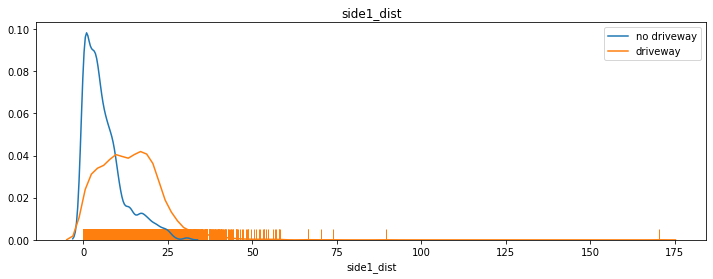

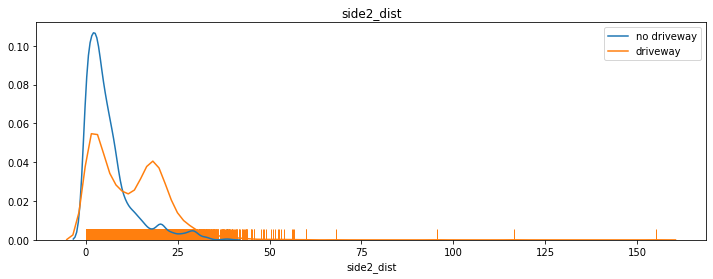

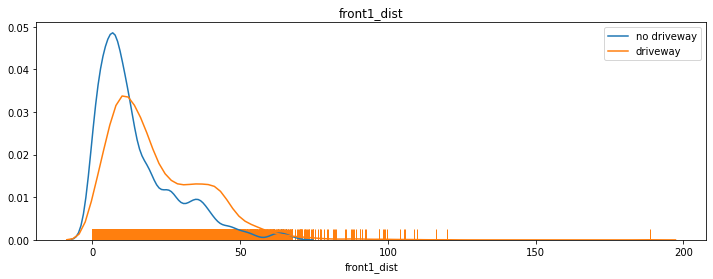

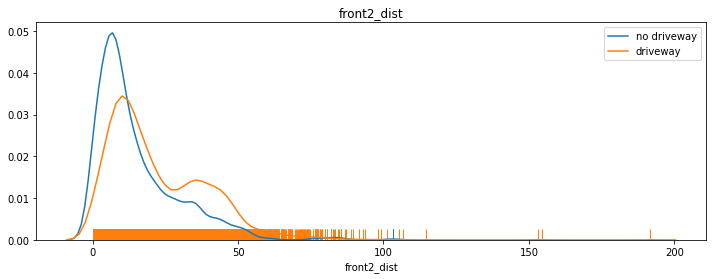

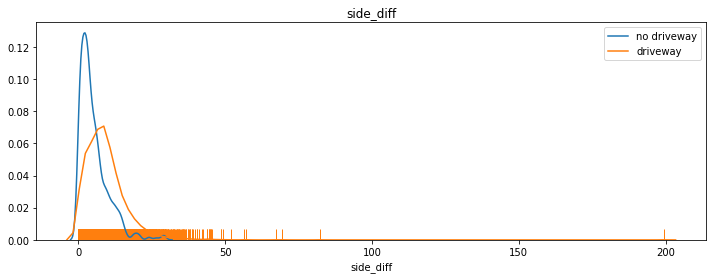

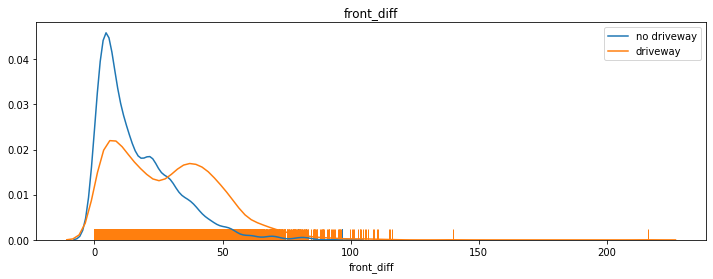

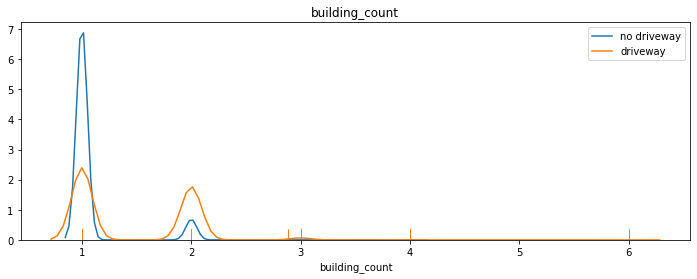

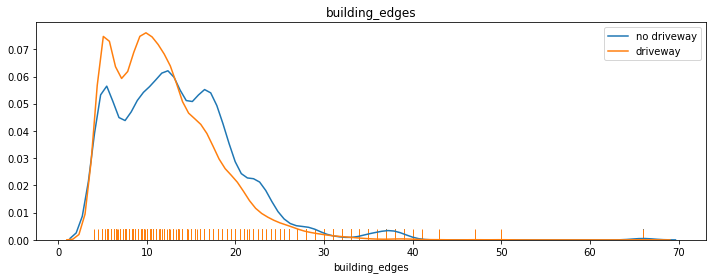

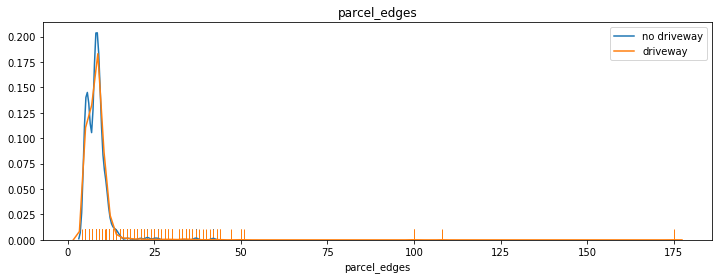

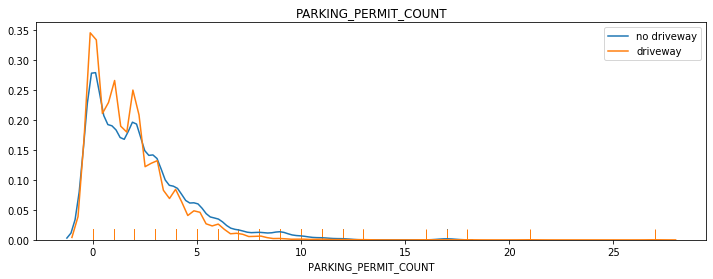

In [132]:
for clm in df_viz.columns:
    try:
        sns.distplot(df_viz[df.has_parking == 0][clm], label = 'no driveway', rug=True, hist=False)
        sns.distplot(df_viz[df.has_parking == 1][clm], label = 'driveway', rug=True, hist=False)
        plt.legend()
        plt.title(clm)
        plt.show()
    except:
        pass

In [133]:
for idx, x in enumerate(df_viz.corr()['has_parking']):
    print(df_viz.corr()['has_parking'].index[idx])
    print(x)

has_parking
1.0
BLDG_VAL
-0.019980893862255062
LAND_VAL
0.10983836408719817
OTHER_VAL
-0.018912569158393205
LOT_SIZE
0.10571775106874635
LS_PRICE
-0.059058585633042636
YEAR_BUILT
0.07857401381050236
BLD_AREA
0.07026477955795844
UNITS
0.023857654025822114
RES_AREA
0.03905613181280754
STORIES
0.12819900677141804
NUM_ROOMS
0.06076612204792678
LOT_UNITS
-0.019507536103138566
BLD_AREA_MISSING
-0.10808799059233208
BLDG_VAL_MISSING
-0.10095056954223415
LOT_SIZE_MISSING
-0.12102791316093874
LS_YEAR
-0.13163047812503298
101
0.028823260476160056
102
0.012224342280277732
104
-0.03729670756668452
105
-0.03610639655080445
111
-0.023551792327801795
112
0.009111171981333795
130
0.009111171981333158
322
-0.03460272494417409
325
nan
326
-0.04169502687052799
332
nan
340
0.015782375981948916
995
-0.10095056954223415
1010
-0.005676504419093501
1020
-0.12497049575096496
1040
0.13828544560537193
1050
0.0017180369175944822
1090
0.020721012873267407
1110
-0.057520686026876586
1120
0.013599340753569045
1220
0.

# Prep Data

In [134]:
df = df[df.has_parking != 2]

df_train, df_test = train_test_split(df, test_size = 0.2)

df_train_up = upsample(df_train)
df_test_up = upsample(df_test)


X_train, y_train = df_train_up[tabular.columns].drop('MBL', axis = 1), df_train_up['has_parking']
X_test, y_test = df_test_up[tabular.columns].drop('MBL', axis = 1), df_test_up['has_parking']

X_train_original, y_train_original = df_train[tabular.columns].drop('MBL', axis = 1), df_train['has_parking']
X_test_original, y_test_original = df_test[tabular.columns].drop('MBL', axis = 1), df_test['has_parking']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_original = scaler.transform(X_train_original)
X_test_original = scaler.transform(X_test_original)


now = datetime.now()

with open(f'../models/scaler_{now}.txt', 'wb') as f:
    pickle.dump(scaler, f)

# poly = PolynomialFeatures(degree = 1)
# X_train = poly.fit_transform(X_train)
# X_test = poly.transform(X_test)

y_test = y_test.apply(lambda x: 1 if x > .5 else 0)
y_train = y_train.apply(lambda x: 1 if x > .5 else 0)
y_train_original = y_train_original.apply(lambda x: 1 if x > .5 else 0)
y_test_original = y_test_original.apply(lambda x: 1 if x > .5 else 0)

In [135]:
X_train.shape

(9242, 113)

In [136]:
y_train.value_counts()

1    4621
0    4621
Name: has_parking, dtype: int64

In [137]:
X_test.shape

(2304, 113)

In [138]:
y_test.value_counts()

1    1152
0    1152
Name: has_parking, dtype: int64

# Logistic Regression

In [284]:
lr = LogisticRegression(C = 1e-3, penalty = 'l2', max_iter = 300)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('validation stats on upsampled test set:')
# validate on upsampled
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# validate on original data
print('validation stats on regular test set:')
y_pred_original = lr.predict(X_test_original)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

validation stats on upsampled test set:
[[871 281]
 [324 828]]
             precision    recall  f1-score   support

          0       0.73      0.76      0.74      1152
          1       0.75      0.72      0.73      1152

avg / total       0.74      0.74      0.74      2304

validation stats on regular test set:
[[ 77  25]
 [324 828]]
             precision    recall  f1-score   support

          0       0.19      0.75      0.31       102
          1       0.97      0.72      0.83      1152

avg / total       0.91      0.72      0.78      1254



In [140]:
now = datetime.now()

with open(f'../models/logreg_{now}.txt', 'wb') as f:
    pickle.dump(lr, f)

In [141]:
# validate on original certain
# validate on original data
y_pred_original_proba = lr.predict_proba(X_test_original)
y_pred_original = lr.predict(X_test_original)
threshold = .2
is_certain_pred = np.absolute(y_pred_original_proba[:,1] - 0.5) > threshold
print(classification_report(y_test_original[is_certain_pred],y_pred_original[is_certain_pred]))
print(sum(is_certain_pred)/len(is_certain_pred))

             precision    recall  f1-score   support

          0       0.38      0.86      0.53        49
          1       0.99      0.89      0.93       600

avg / total       0.94      0.88      0.90       649

0.5175438596491229


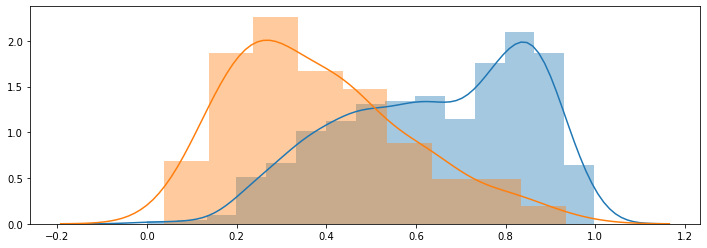

In [142]:
sns.distplot(y_pred_original_proba[:,1][y_test_original == 1])
sns.distplot(y_pred_original_proba[:,1][y_test_original == 0])

In [143]:
param_dict = dict(zip(df_test[tabular.columns].drop('MBL', axis = 1).columns, lr.coef_.reshape(-1)))

param_dict

{'BLDG_VAL': 0.03031214464509934,
 'LAND_VAL': 0.08471094548677836,
 'OTHER_VAL': -0.18712004470161261,
 'LOT_SIZE': 0.10785303142169654,
 'LS_PRICE': -0.07699336573564537,
 'YEAR_BUILT': 0.06525082911802879,
 'BLD_AREA': 0.04315870716016031,
 'UNITS': -0.028537370582289237,
 'RES_AREA': 0.028233270966043028,
 'STORIES': 0.13211890675157625,
 'NUM_ROOMS': 0.05223015841866212,
 'LOT_UNITS': -0.0238244021810698,
 'BLD_AREA_MISSING': -0.11441514449195446,
 'BLDG_VAL_MISSING': -0.017723754487158995,
 'LOT_SIZE_MISSING': -0.03854153551265666,
 'LS_YEAR': -0.12386276044549493,
 '101': 0.04618388818325926,
 '102': 0.0035145407622427407,
 '104': -0.05950145045191026,
 '105': -0.01886870597283043,
 '111': -0.010636340052330181,
 '112': 0.003135898196317695,
 '130': 0.0363165156628188,
 '322': -0.044113449570020107,
 '325': 0.0,
 '326': -0.015217754106690256,
 '332': 0.0,
 '340': 0.041841591250497634,
 '995': -0.017723754487158995,
 '1010': 0.0003218097638191697,
 '1020': -0.03357761671128233,
 

In [144]:
tabular_labels = tabular.merge(labels_clean, how = 'left')
tabular_without_labels = tabular_labels[tabular_labels.has_parking.isna()].drop(['MBL','has_parking'], axis = 1)
X_no_label = scaler.transform(tabular_without_labels)
y_proba = lr.predict_proba(X_no_label)

In [145]:
sum(y_proba[:,1] > .5) + len(labels_clean)

9270

(array([0.02739726, 0.12435233, 0.18004866, 0.33421751, 0.54302671,
       0.64685315, 0.77358491, 0.91358025, 1.        ]), array([0.18962131, 0.25596883, 0.35199989, 0.45028916, 0.55498278,
       0.64832715, 0.74612218, 0.85822655, 0.92247854]))


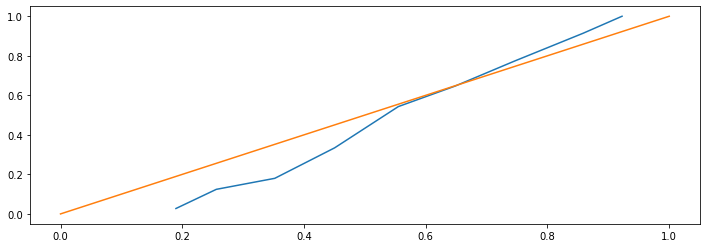

In [285]:
res = calibration_curve(y_test, y_pred_proba[:,1], n_bins=10)
print(res)
plt.plot(res[1], res[0])
plt.plot(np.linspace(0,1,20), np.linspace(0,1,20))

## Logistic Regression w/ Interactions

In [159]:
# select features for interaction with lasso
lr = LogisticRegression(C = 0.005, penalty = 'l1', max_iter = 300, solver = 'liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
# validate on upsampled
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

interaction_columns = [clm 
                       for idx, clm in enumerate(df_test[tabular.columns].drop('MBL', axis = 1)) 
                       if lr.coef_.reshape(-1)[idx] > 0]

training_clms = df_train_up[tabular.columns].drop('MBL', axis = 1).columns
interaction_clms_idx = [idx for idx, clm in enumerate(training_clms) if clm in interaction_columns]
non_interaction_clms_idx = [idx for idx, clm in enumerate(training_clms) if clm not in interaction_columns]

[[879 273]
 [353 799]]
             precision    recall  f1-score   support

          0       0.71      0.76      0.74      1152
          1       0.75      0.69      0.72      1152

avg / total       0.73      0.73      0.73      2304



In [160]:
poly = PolynomialFeatures(degree = 2)
X_train_interact = poly.fit_transform(X_train[:,interaction_clms_idx])
X_test_interact = poly.transform(X_test[:,interaction_clms_idx])
X_test_original_interact = poly.transform(X_test_original[:,interaction_clms_idx])


X_train_interact = np.concatenate([X_train_interact, X_train[:,non_interaction_clms_idx]], axis = 1)
X_test_interact = np.concatenate([X_test_interact, X_test[:,non_interaction_clms_idx]], axis = 1)
X_test_original_interact = np.concatenate([X_test_original_interact, X_test_original[:,non_interaction_clms_idx]], axis = 1)

In [161]:
X_train_interact.shape

(9242, 169)

In [169]:
lr = LogisticRegression(C = 1e2, penalty = 'l2', max_iter = 300)
lr.fit(X_train_interact, y_train)

# validate on upsampled
y_pred = lr.predict(X_train_interact)
print(confusion_matrix(y_train,y_pred))
print(classification_report(y_train,y_pred))

# validate on upsampled
y_pred = lr.predict(X_test_interact)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# validate on original data
y_pred_original = lr.predict(X_test_original_interact)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

[[3747  874]
 [1178 3443]]
             precision    recall  f1-score   support

          0       0.76      0.81      0.79      4621
          1       0.80      0.75      0.77      4621

avg / total       0.78      0.78      0.78      9242

[[787 365]
 [280 872]]
             precision    recall  f1-score   support

          0       0.74      0.68      0.71      1152
          1       0.70      0.76      0.73      1152

avg / total       0.72      0.72      0.72      2304

[[ 72  30]
 [280 872]]
             precision    recall  f1-score   support

          0       0.20      0.71      0.32       102
          1       0.97      0.76      0.85      1152

avg / total       0.90      0.75      0.81      1254



# Support Vector Machine

In [170]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [171]:
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

y_pred_original = svclassifier.predict(X_test_original)
print(confusion_matrix(y_test_original, y_pred_original))
print(classification_report(y_test_original, y_pred_original))

[[750 402]
 [234 918]]
             precision    recall  f1-score   support

          0       0.76      0.65      0.70      1152
          1       0.70      0.80      0.74      1152

avg / total       0.73      0.72      0.72      2304

[[ 66  36]
 [234 918]]
             precision    recall  f1-score   support

          0       0.22      0.65      0.33       102
          1       0.96      0.80      0.87      1152

avg / total       0.90      0.78      0.83      1254



In [33]:
now = datetime.now()

with open(f'../models/svc_{now}.txt', 'wb') as f:
    pickle.dump(svclassifier, f)

# XGBoost

In [34]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [35]:
try:
    df = df.drop(['MBL','AERIAL_Driveway', 'GSV_Driveway'], axis = 1)
except KeyError:
    pass

df.has_parking = df.has_parking.apply(lambda x: 1 if x > .5 else 0)

train = df
target = 'has_parking'
IDcol = 'MBL'

/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [36]:
count = train.has_parking.value_counts()
scale = count[0]/count[1]
scale

0.09269923834293145

In [37]:
def modelfit(alg, dtrain, predictors, cv_folds=5, early_stopping_rounds=300):
    xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
    alg.set_params(n_estimators=cvresult.shape[0])
    print(cvresult.shape[0])
    return cvresult.shape[0]

In [38]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=scale,
 seed=27)

predictors = [x for x in train.columns if x not in [target, IDcol]]
best_n_estimators = modelfit(xgb1, train, predictors)

59


In [39]:
param_test1 = {
 'max_depth':[2,3,4],
 'min_child_weight':[5,6,7]
}

gsearch1 = (
    GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=best_n_estimators, max_depth=5,
                 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                 objective= 'binary:logistic', nthread=4, scale_pos_weight=scale, seed=27), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

KeyboardInterrupt: 

In [ ]:
gsearch1.best_params_

In [ ]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(
    estimator = XGBClassifier( 
        learning_rate =0.1, 
        n_estimators=best_n_estimators, 
        max_depth=gsearch1.best_params_['max_depth'],
        min_child_weight=gsearch1.best_params_['min_child_weight'], 
        gamma=0, 
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=scale,
        seed=27), 
    param_grid = param_test2, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False,
    cv=5
)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

In [ ]:
xgb2 = XGBClassifier(
    learning_rate =0.1, 
    n_estimators=1000, 
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'], 
    gamma=gsearch2.best_params_['gamma'], 
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4, 
    scale_pos_weight=scale,
    seed=27
)
best_n_estimators = modelfit(xgb2, train, predictors)

In [ ]:
xgb3 = XGBClassifier(
    learning_rate =0.1, 
    n_estimators=best_n_estimators, 
    max_depth=gsearch1.best_params_['max_depth'],
    min_child_weight=gsearch1.best_params_['min_child_weight'], 
    gamma=gsearch2.best_params_['gamma'], 
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4, 
    scale_pos_weight=scale,
    seed=27
)

In [ ]:
# fit model
train, test = train_test_split(df, test_size = 0.2)

In [ ]:
xgb3.fit(train[predictors], train[target])
y_pred = xgb3.predict(test[predictors])
sum(y_pred == test[target])/len(test[target])

In [ ]:
y_pred = xgb3.predict(test[predictors])
print(classification_report(test[target],y_pred))

# Neural Network

In [172]:
import pandas
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise
from keras.optimizers import Adam


In [178]:
batch_size = 16
epochs = 20

model = Sequential()
model.add(GaussianNoise(0.1, input_shape = (X_train.shape[1], )))
model.add(Dense(25, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# Compile model
adam = Adam(lr = 1e-4)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_7 (GaussianNo (None, 113)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 25)                2850      
_________________________________________________________________
batch_normalization_18 (Batc (None, 25)                100       
_________________________________________________________________
dropout_18 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 25)                650       
_________________________________________________________________
batch_normalization_19 (Batc (None, 25)                100       
_________________________________________________________________
dropout_19 (Dropout)         (None, 25)               

KeyboardInterrupt: 

## Random Forest

In [179]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400

In [223]:
rf_up = RandomForestClassifier(bootstrap = True, n_estimators=400, max_depth=6)
rf_up.fit(X_train, y_train)
y_pred = rf_up.predict(X_test)

print('validation stats on upsampled test set:')
# validate on upsampled
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# validate on original data
print('validation stats on regular test set:')
y_pred_original = rf_up.predict(X_test_original)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

validation stats on upsampled test set:
[[828 324]
 [226 926]]
             precision    recall  f1-score   support

          0       0.79      0.72      0.75      1152
          1       0.74      0.80      0.77      1152

avg / total       0.76      0.76      0.76      2304

validation stats on regular test set:
[[ 73  29]
 [226 926]]
             precision    recall  f1-score   support

          0       0.24      0.72      0.36       102
          1       0.97      0.80      0.88      1152

avg / total       0.91      0.80      0.84      1254



In [266]:
y_pred = rf_up.predict(X_test)
y_pred_proba = rf_up.predict_proba(X_test)
certain = y_pred_proba[:,1] < 0.25

print('validation stats on upsampled test set:')
# validate on upsampled
print(confusion_matrix(y_test[certain], y_pred[certain]))
print(classification_report(y_test[certain], y_pred[certain]))

validation stats on upsampled test set:
[[136   0]
 [ 13   0]]
             precision    recall  f1-score   support

          0       0.91      1.00      0.95       136
          1       0.00      0.00      0.00        13

avg / total       0.83      0.91      0.87       149



/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
with open(f'../models/random_forest_{now}.txt', 'wb') as f:
    pickle.dump(rf_up, f)

(array([0.02739726, 0.12435233, 0.18004866, 0.33421751, 0.54302671,
       0.64685315, 0.77358491, 0.91358025, 1.        ]), array([0.18962131, 0.25596883, 0.35199989, 0.45028916, 0.55498278,
       0.64832715, 0.74612218, 0.85822655, 0.92247854]))


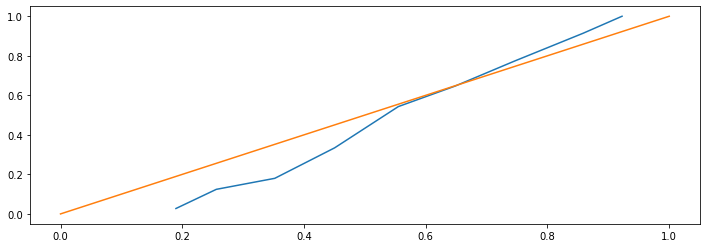

In [282]:
from sklearn.calibration import calibration_curve
res = calibration_curve(y_test, y_pred_proba[:,1], n_bins=10)
print(res)
plt.plot(res[1], res[0])
plt.plot(np.linspace(0,1,20), np.linspace(0,1,20))

## Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier

models = [('rf', rf_up),('svc', svclassifier), ('lr',lr)]

stack = StackingClassifier(models)
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

In [ ]:
print('validation stats on upsampled test set:')
# validate on upsampled
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

# validate on original data
print('validation stats on regular test set:')
y_pred_original = stack.predict(X_test_original)
print(confusion_matrix(y_test_original,y_pred_original))
print(classification_report(y_test_original,y_pred_original))

## Random Forest Performed Best - Find the Certain Predictions

In [235]:
tabular_no_labels = tabular.merge(labels_clean, how = 'left')
tabular_no_labels = tabular_no_labels[tabular_no_labels.has_parking.isna()]

In [237]:
y_pred = rf_up.predict(
    scaler.transform(
        tabular_no_labels[tabular.columns].drop(['MBL'], axis = 1)
    )
)

y_pred_proba = rf_up.predict_proba(
    scaler.transform(
        tabular_no_labels[tabular.columns].drop(['MBL'], axis = 1)
    )
)

In [245]:
certain = np.absolute(y_pred_proba[:,1] - 0.5) > 0.2

In [246]:
tabular_no_labels['has_parking_pred'] = np.nan

In [247]:
tabular_no_labels.has_parking_pred[certain] = y_pred[certain]

/Users/joshfeldman/Harvard/Courses/Fall2019/Capstone/AC297r_2019_somerville_parking/somerville/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [248]:
sum(certain)

1471

In [249]:
sum(tabular_no_labels.has_parking_pred == 1)

973

In [250]:
sum(tabular_no_labels.has_parking_pred == 0)

498

In [251]:
len(df)

6269

In [253]:
sum(certain) + len(labels_clean)

7951

In [254]:
len(tabular)

11704

In [255]:
len(tabular) - (sum(certain) + len(labels_clean))

3753

In [252]:
tabular_no_labels[tabular_no_labels.has_parking_pred == 0]

MBL      BLDG_VAL      LAND_VAL      OTHER_VAL  LOT_SIZE      LS_PRICE  YEAR_BUILT      BLD_AREA     UNITS      RES_AREA   STORIES  NUM_ROOMS  LOT_UNITS  BLD_AREA_MISSING  BLDG_VAL_MISSING  LOT_SIZE_MISSING      LS_YEAR  101  102  104  105  111  112  130  322  325  326  332  340       995  1010      1020  1040   1050  1090  1110  1120  1220  9450  9570  9610  9700  112C  957R  959R  970C  ASMD   BA   BB  CBD  CCD45  CCD55   IA   IP    NB   OS        RA        RB    RC  TOD 100  TOD55  TOD70   UN        rb  2 Fam Conv  2-Decker  2-Decker-Apts  3 fam Conv  3-Decker  3-Decker-Apts  Apartments  Condominium  Conventional  Conventional-Apts  Cottage  Cottage Bungalow  Duplex  Fam Conv  Family Duplex  Family Duplex-Apts  Low rise  Mansard  Mansard-Apts  Mid Rise Apartments  Mid rise  Row End  Row End-Apts  Row Mid  Row Mid-Apts  Row Middle  Stores/Apt Com  Three decker  Townhouse  Townhouse end  Townhouse middle  Two Family  Two Family-Apts  Two decker  Victorian  1ST_CLOSEST  \
123     102-B-6  3.925000e+05  2.275000e+05   17888.245551  0.030000  1.000000e+01      1900.0   3345.000000  4.215987   2161.000000  2.800000  16.000000  10.207792          0.000000          0.000000          0.000000  2001.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   0.0  0.000000   0.0  0.000   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0    0.0    0.0  0.0  0.0  0.00  0.0  0.000000  0.000000  0.00      0.0    0.0    1.0  0.0  0.000000         0.0       0.0            0.0       0.000       0.0            0.0         0.0     0.000000           0.0                0.0      0.0               0.0    0.00  0.000000            0.0                 0.0       0.0      0.0           0.0                  0.0       0.0      0.0           1.0      0.0           0.0        0.00             0.0      0.000000        0.0            0.0               0.0    0.000000              0.0    0.000000        0.0     4.897906   
129     102-C-5  3.664000e+05  2.307000e+05   17888.245551  0.040000  2.068000e+05      1900.0   4269.000000  4.215987   2728.000000  3.000000  12.000000  10.207792          0.000000          0.000000          0.000000  2001.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   0.0  0.000000   0.0  1.000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0    1.0    0.0  0.0  0.0  0.00  0.0  0.000000  0.000000  0.00      0.0    0.0    0.0  0.0  0.000000         0.0       0.0            0.0       1.000       0.0            0.0         0.0     0.000000           0.0                0.0      0.0               0.0    0.00  0.000000            0.0                 0.0       0.0      0.0           0.0                  0.0       0.0      0.0           0.0      0.0           0.0        0.00             0.0      0.000000        0.0            0.0               0.0    0.000000              0.0    0.000000        0.0     2.597852   
162    102-E-17  5.017763e+05  5.353694e+05   17888.245551  0.134779  3.465582e+05      1900.0   2387.642842  3.477325   1734.965940  2.136210   6.965865  10.207792          0.333333          0.333333          1.000000  2005.843216  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.333333   0.0  0.666667   0.0  0.000   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0    0.0    0.0  0.0  0.0  0.00  0.0  0.666667  0.000000  0.00      0.0    0.0    0.0  0.0  0.000000         0.0       0.0            0.0       0.000       0.0            0.0         0.0     0.333333           0.0                0.0      0.0               0.0    0.00  0.000000            0.0                 0.0       0.0      0.0           0.0                  0.0       0.0      0.0           0.0      0.0           0.0        0.00             0.0      0.000000        0.0            0.0               0.0    0.666667              0.0    0.000000        0.0    11.769211   
169     102-E-9 

## Check MBLs

In [265]:
mbl = '38-A-13'
rf_up.predict_proba(scaler.transform(tabular[tabular.MBL == mbl].drop('MBL', axis = 1)))

array([[0.6390158, 0.3609842]])